In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn import datasets 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans




In [0]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [0]:
X = pd.read_csv('reduced_df.csv') 

  
# Dropping the CUST_ID column from the data 
  
# Handling the missing values 
X.fillna(method ='ffill', inplace = True) 
  
print(X.head()) 

   Unnamed: 0  BALANCE_FREQUENCY  ONEOFF_PURCHASES  ...  installment  none  one_off
0           0           0.597837          0.000000  ...            1     0        0
1           1           0.646627          0.000000  ...            0     1        0
2           2           0.693147          6.651791  ...            0     0        1
3           3           0.492477          7.313220  ...            0     0        1
4           4           0.693147          2.833213  ...            0     0        1

[5 rows x 18 columns]


In [0]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_principal = pd.DataFrame(X_normalized) 

In [0]:
print(X_principal.head()) 

         0         1         2   ...        15        16        17
0 -0.472176 -0.040557 -0.269122  ...  0.469084 -0.148233 -0.140308
1 -0.376589  0.039066 -0.214689  ... -0.126414  0.400038 -0.111929
2 -0.370065  0.105330  0.227036  ... -0.124251 -0.116228  0.415403
3 -0.414960 -0.205686  0.303489  ... -0.139356 -0.130358  0.465902
4 -0.430989  0.122725 -0.028472  ... -0.144772 -0.135424  0.484007

[5 rows x 18 columns]


In [0]:
km=KMeans(n_clusters=4,random_state=123)
km.fit(X_principal)
labels=km.labels_

In [0]:
labels

array([2, 3, 0, ..., 2, 3, 0], dtype=int32)

We find that , its best performing for Affic as RBF and Number of clusters 5

In [0]:
from sklearn import metrics
from sklearn.metrics import calinski_harabaz_score,silhouette_score
best_sil_score=silhouette_score(X_principal,labels)
best_cal_score=calinski_harabaz_score(X_principal,labels)
print('Silhouette Score is {}'.format(best_sil_score))
print('Calinski_harabaz Score is {}'.format(best_cal_score))

Silhouette Score is 0.3653081851371991
Calinski_harabaz Score is 4009.060244961023


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


In [0]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [0]:
X_principal.shape

(8950, 18)

In [0]:
dims = [X_principal.shape[-1], 15, 12, 30, 5]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

In [0]:
autoencoder, encoder = autoencoder(dims, init=init)

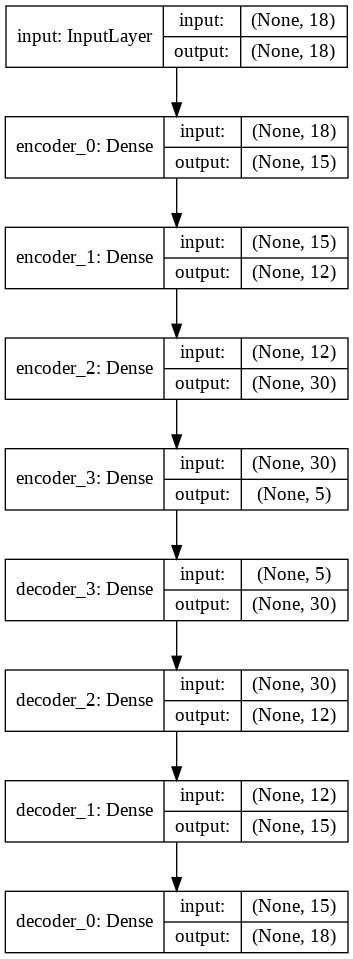

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

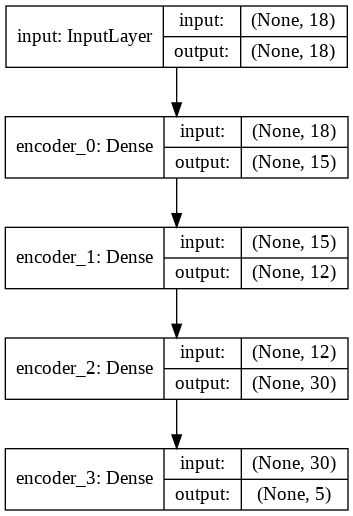

In [0]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

In [0]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(X_principal, X_principal, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights('ae_weights.h5')

Epoch 1/300
8950/8950 [==============================] - 0s 16us/step - loss: 0.0555
Epoch 2/300
8950/8950 [==============================] - 0s 8us/step - loss: 0.0545
Epoch 3/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0390
Epoch 4/300
8950/8950 [==============================] - 0s 8us/step - loss: 0.0359
Epoch 5/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0350
Epoch 6/300
8950/8950 [==============================] - 0s 9us/step - loss: 0.0295
Epoch 7/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0224
Epoch 8/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0208
Epoch 9/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0194
Epoch 10/300
8950/8950 [==============================] - 0s 7us/step - loss: 0.0180
Epoch 11/300
8950/8950 [==============================] - 0s 8us/step - loss: 0.0161
Epoch 12/300
8950/8950 [==============================] - 0s 7us/step - l

In [0]:
autoencoder.load_weights('ae_weights.h5')

In [0]:
n_clusters=4

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = 5
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clustering')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [0]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

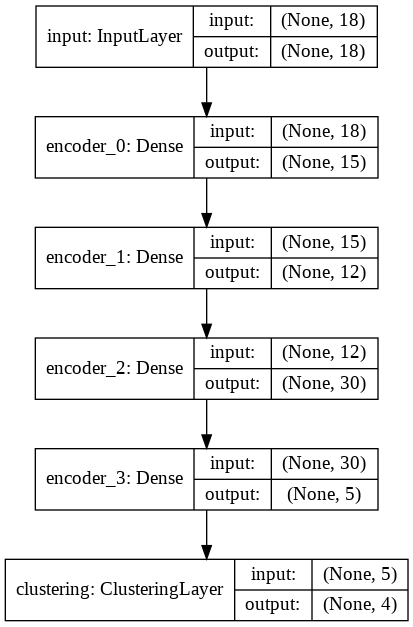

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [0]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X_principal))

In [0]:
from sklearn import metrics
from sklearn.metrics import calinski_harabaz_score,silhouette_score
best_sil_score=silhouette_score(X_principal,y_pred)
best_cal_score=calinski_harabaz_score(X_principal,y_pred)
print('Silhouette Score is {}'.format(best_sil_score))
print('Calinski_harabaz Score is {}'.format(best_cal_score))

Silhouette Score is 0.3603382188585899
Calinski_harabaz Score is 3921.5820379171378


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
